In [6]:
from keras.models import Sequential
import keras
from keras.utils import np_utils
import preprocessing
import postprocessing
import os
from os import listdir
from os.path import isfile, join, isdir
import numpy as np
import pickle

## set up initial variables

In [3]:
#create class to keep track of configutation (combination of notes) frequency
class VocabMap:
    def __init__(self):
        self.vocab = {}
        self.num = 0
        self.backwards = {}
        self.vocab_count = {}
    def addToMap(self, newStr):
        if newStr not in self.vocab:
            self.vocab[newStr] = self.num
            self.backwards[self.num] = newStr
            self.vocab_count[self.num] = 1
            self.num += 1
        else:
            self.vocab_count[self.vocab[newStr]] += 1
    def get(self,k):
        return self.vocab[k]
    def __len__(self):
        return len(self.vocab)
    def restore(self, st):
        return self.backwards[st]
    def remove(self,num):
        st = self.backwards[num]
        del self.backwards[num]
        del self.vocab[st]
        del self.vocab_count[num]
    def remove_count(self, num, amount):
        self.vocab_count[num] -= amount

sequence_length = 100 #length of a sequence per sample
#load the smushed midi files (multiple tracks that were combined to one beforehand)
pwd = os.path.dirname(os.path.realpath('__file__'))
smushed = os.path.join(pwd, "midi-files","Smushed")
smushedMidis = [f for f in listdir(smushed) if isfile(join(smushed, f))]
print("No of midi files: {0}".format(len(smushedMidis)))


sampleSize = 100000 #max number of samples to collect
net_i = 0 #size of network
network_input = [] #will contain the input samples (sequenceLength each)
network_output = [] #will contain one configuration per sample (what comes at sequenceLength+1)
vocab_map = VocabMap()
zeroVec = np.zeros(72,int) #the rest vector
vocab_map.addToMap("000000000000000000000000000000000000000000000000000000000000000000000000")
print("zeroVec at: {0}".format(vocab_map.get("000000000000000000000000000000000000000000000000000000000000000000000000")))


No of midi files: 317
zeroVec at: 0


## Collect samples from the midi files
Note that we don't collect samples that have more than 25% of rests. This is because our data contains empty tracks and near empty tracks (for example guitar roles with only one or two bars in the song).
We add each note configuration to a map so we can identify how many different configurations are present in the data, and so we can categorize them easily later

In [4]:
for fi, f in enumerate(smushedMidis[:200]): #for each midi file
    print("{1}: Processing {0}".format(f, fi))
    path = os.path.join(smushed, f)
    mat = preprocessing.convertTrackNoInstruments(path) #get the matrix represenation of the track
    if mat is None:
        print("Nothing to process...moving on")
        continue
    
    start_col = 0 #column to start collecting samples from
    count = 1 #counts the number of samples collected per track
    no_batches = 30
    while count < 2000 and no_batches > 0 and start_col + sequence_length*2 < mat.shape[1] and net_i < sampleSize:
        for i in range(start_col, start_col + sequence_length):
            seq_in = []
            countZeros = 0
            for j,vec in enumerate(mat[:,i:i+sequence_length].T):
                vecSt = ''.join([str(k) for k in vec])
                vocab_map.addToMap(vecSt)
                noteInt = vocab_map.get(vecSt)
                seq_in.append(noteInt)
                if noteInt == 0:
                    countZeros += 1
            if countZeros > sequence_length//4:
                vocab_map.remove_count(0, countZeros)
                continue
            
            network_input.append(seq_in)
            outVecSt = ''.join([str(i) for i in mat[:,i+sequence_length]])
            vocab_map.addToMap(outVecSt)
            network_output.append(vocab_map.get(outVecSt))
            #print("Sequence {0} \n Output: {1}".format(seq_in, vocab_map.get(outVecSt)))
            net_i += 1
            if net_i >= sampleSize:
                break
            count += 1
            if count >= 200:
                break
        no_batches -= 1
        start_col += 100
    print("Added {0} patterns (of size {2}) from {1}".format(count, f, sequence_length))

print(net_i)


0: Processing Unforgiven_3.mid
1
Added 215 patterns (of size 100) from Unforgiven_3.mid
1: Processing Michelle_2.mid
1
Added 1 patterns (of size 100) from Michelle_2.mid
2: Processing Squealer.mid
1
Added 224 patterns (of size 100) from Squealer.mid
3: Processing Shes_A_Rebel.mid
1
Added 209 patterns (of size 100) from Shes_A_Rebel.mid
4: Processing Harvester_Of_Sorrow_3.mid
1
Added 218 patterns (of size 100) from Harvester_Of_Sorrow_3.mid
5: Processing Money_Talks.mid
1
Added 216 patterns (of size 100) from Money_Talks.mid
6: Processing Dirty_Deeds_Done_Dirt_Cheap.mid
1
Added 216 patterns (of size 100) from Dirty_Deeds_Done_Dirt_Cheap.mid
7: Processing Pretty_Fly_For_A_White_Guy_1.mid
1
Added 210 patterns (of size 100) from Pretty_Fly_For_A_White_Guy_1.mid
8: Processing Rock_Licks_-_Some_Licks_From_Jimmy_Page.mid
1
Added 219 patterns (of size 100) from Rock_Licks_-_Some_Licks_From_Jimmy_Page.mid
9: Processing Running_On_Faith.mid
1
Added 212 patterns (of size 100) from Running_On_Fait

Added 74 patterns (of size 100) from With_A_Little_Help_From_My_Friends.mid
89: Processing Breed_3.mid
1
Added 215 patterns (of size 100) from Breed_3.mid
90: Processing Been_A_Son_2.mid
1
Added 209 patterns (of size 100) from Been_A_Son_2.mid
91: Processing Oh_George.mid
1
Added 212 patterns (of size 100) from Oh_George.mid
92: Processing Alcohol.mid
1
Added 214 patterns (of size 100) from Alcohol.mid
93: Processing Goin_Back.mid
1
Added 213 patterns (of size 100) from Goin_Back.mid
94: Processing Nothing_Else_Matters.mid
1
Added 216 patterns (of size 100) from Nothing_Else_Matters.mid
95: Processing Because.mid
1
Added 207 patterns (of size 100) from Because.mid
96: Processing Act_Naturally.mid
1
Added 135 patterns (of size 100) from Act_Naturally.mid
97: Processing 16.mid
1
Added 216 patterns (of size 100) from 16.mid
98: Processing All_Apologies_4.mid
1
Added 1 patterns (of size 100) from All_Apologies_4.mid
99: Processing Another_Brick_In_The_Wall_3.mid
1
Added 212 patterns (of si

1
Added 205 patterns (of size 100) from All_My_Lovin.mid
177: Processing Michelle.mid
1
Added 1 patterns (of size 100) from Michelle.mid
178: Processing Last_Caress.mid
1
Added 208 patterns (of size 100) from Last_Caress.mid
179: Processing Best_Of_My_Love.mid
1
Added 181 patterns (of size 100) from Best_Of_My_Love.mid
180: Processing Ride_On.mid
1
Added 215 patterns (of size 100) from Ride_On.mid
181: Processing Come_Together.mid
1
Added 67 patterns (of size 100) from Come_Together.mid
182: Processing Everybodys_Got_Something_To_Hide_Except_For_Me_And_My_Monkey.mid
1
Added 209 patterns (of size 100) from Everybodys_Got_Something_To_Hide_Except_For_Me_And_My_Monkey.mid
183: Processing Unwante.mid
1
Added 209 patterns (of size 100) from Unwante.mid
184: Processing This_Is_A_Call.mid
1
Added 215 patterns (of size 100) from This_Is_A_Call.mid
185: Processing Brainstew_2.mid
1
Added 201 patterns (of size 100) from Brainstew_2.mid
186: Processing Bad_Love.mid
1
Added 220 patterns (of size 1

In [7]:
#Save the data collected to file for easy load in the future
vocab_dest = os.path.join(pwd, "saved_data", 'processed_200_NOT_filtered_vocab_test.pkl')
input_dest = os.path.join(pwd, "saved_data", 'processed_200_NOT_filtered_net_input_test.txt')
output_dest = os.path.join(pwd, "saved_data", 'processed_200_NOT_filtered_net_output_test.txt')

with open(vocab_dest, 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(vocab_map, f)
    
np.savetxt(input_dest, network_input, fmt='%d')
np.savetxt(output_dest, network_output, fmt='%d')

## Examine the data
Here we want to see if the distribution of notes is reasonable. 

[0, 33, 188, 36, 10, 37, 396, 12, 334, 19]
[258690, 195349, 156727, 148021, 120066, 110673, 109130, 101014, 100714, 94840]


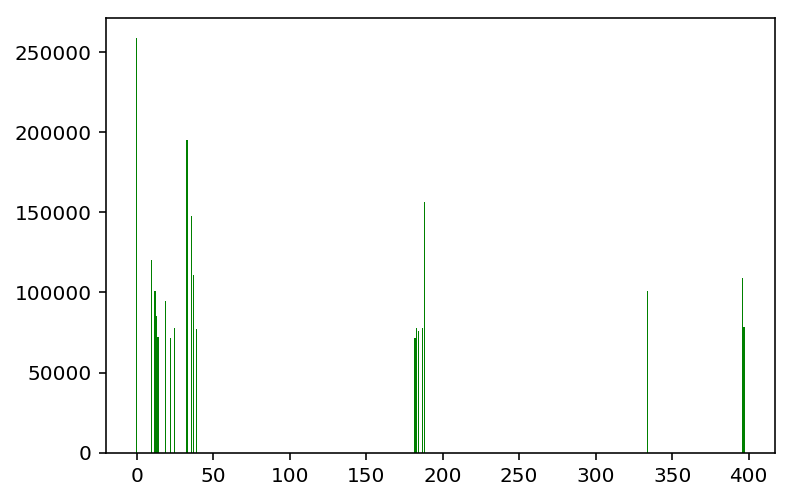

vector 0
 count: 258690
vector 33
 count: 195349
vector 188
 count: 156727
vector 36
 count: 148021
vector 10
 count: 120066
vector 37
 count: 110673
vector 396
 count: 109130
vector 12
 count: 101014
vector 334
 count: 100714
vector 19
 count: 94840
vector 13
 count: 85154
vector 397
 count: 78315
vector 25
 count: 77975
vector 183
 count: 77749
vector 187
 count: 77525


In [8]:
import matplotlib.pyplot as plt
dict_keys = [k for k,v in sorted([(k,v) for k,v in vocab_map.vocab_count.items()], key=lambda tup: tup[1])[::-1]]
dict_vals = sorted([v for k,v in vocab_map.vocab_count.items()])[::-1]
print(dict_keys[:10])
print(dict_vals[:10])
assert vocab_map.vocab_count[dict_keys[5]] == dict_vals[5]
plt.bar(dict_keys[:20], dict_vals[:20], color='g')
plt.show() #show how many appearances we have for each of the 20 most frequent configuration

for i in range(15):
    print("vector {0}\n count: {1}\n=======".format(dict_keys[i], dict_vals[i]))

## Decide what to filter
There are many note configurations that are highly infrequent but blow up the amount of categories we will later need to predict. Our goal is to determine how many such categories we can filter out of the data without shrinking it too much

In [10]:
import copy
input_filtered = np.copy(network_input)
output_filtered = np.copy(network_output)
vocab_filtered = VocabMap()

vocab_filtered.num = copy.deepcopy(vocab_map.num)
vocab_filtered.vocab = copy.deepcopy(vocab_map.vocab)
vocab_filtered.backwards = copy.deepcopy(vocab_map.backwards)
vocab_filtered.vocab_count = copy.deepcopy(vocab_map.vocab_count)

min_appearances = 1000 #the minimum amount of appearances we want to test for
onesi = len(dict_keys) - 1
get_rid_of = []
while onesi > 0:
    if dict_vals[onesi] > min_appearances: 
        break
    get_rid_of.append(dict_keys[onesi])
    onesi -= 1
print("Remaining: {0}".format(onesi)) #amount of categories that will remain
print("Would delete {0} categories".format(len(get_rid_of))) #amount of categories to delete
count_deletes = 0
total = 0
for k in get_rid_of:
    count_deletes += vocab_map.vocab_count[k]
for k,v in vocab_map.vocab_count.items():
    total += v
print("Can delete {0} elements".format((count_deletes))) #amount of data points (total vectors) that will be deleted
print("Out of total of {0} elements".format(total)) #total amount of vectors in our data
print("Ratio of deletions: {0}".format(count_deletes/total)) #amount of vectors we will lose

  

Remaining: 670
Would delete 6006 categories
Can delete 595148 elements
Out of total of 6726517 elements
Ratio of deletions: 0.08847788536028378


## Do the filtering
Here we will replace any unwanted category with the rest vector, and exclude every sample that its total rest vectors after the replacemenet is > 25%

In [ ]:
#load the data to skip previous phases (they take a while...)
vocab_dest = os.path.join(pwd, "saved_data", 'processed_200_NOT_filtered_vocab_test.pkl')
input_dest = os.path.join(pwd, "saved_data", 'processed_200_NOT_filtered_net_input_test.txt')
output_dest = os.path.join(pwd, "saved_data", 'processed_200_NOT_filtered_net_output_test.txt')

network_input = np.loadtxt(input_dest, dtype=int)
network_output = np.loadtxt(output_dest, dtype=int)
with open(vocab_dest,'rb') as f:
    vocab_map = pickle.load(f)

assert len(network_input) == len(network_output)

#collect the unwanted sample indices
remove_indices = []
for seqI,seq in enumerate(network_input):
    if seqI % 3000 == 0:
        print("Progress: seqI = {0}, so far to remove: {1}".format(seqI, len(remove_indices)))
    
    if network_output[seqI] in get_rid_of:
        remove_indices.append(seqI)
        continue
    
    count = 0
    for noteI, noteInt in enumerate(seq):
        if noteInt in get_rid_of or noteInt == 0:
            count += 1
            network_input[seqI][noteI] = 0
        if count > 30:
            remove_indices.append(seqI)
            break
print("Would remove {0} sequences out of {1}".format(len(remove_indices), len(network_input)))
            

Progress: seqI = 0, so far to remove: 0
Progress: seqI = 3000, so far to remove: 487
Progress: seqI = 6000, so far to remove: 1076
Progress: seqI = 9000, so far to remove: 1825
Progress: seqI = 12000, so far to remove: 2920
Progress: seqI = 15000, so far to remove: 3910
Progress: seqI = 18000, so far to remove: 4619
Progress: seqI = 21000, so far to remove: 5245


In [ ]:
#create the final filtered dataset (exclude unwanted samples)
str_to_int = {}
int_to_str = {}
count_int = {}
str_to_int["000000000000000000000000000000000000000000000000000000000000000000000000"] = 0
int_to_str[0] = "000000000000000000000000000000000000000000000000000000000000000000000000"
count_int[0] = 1
nextInt = 1

net_in_filtered = []
net_out_filtered = []
for seqI,seq in enumerate(network_input):
    if seqI % 3000 == 0:
        print("Progress: seqI = {0}".format(seqI))
        
    if seqI in remove_indices:
        continue
    
    noteInt = network_output[seqI]
    noteStr = vocab_map.restore(noteInt)
    
    if noteStr not in str_to_int:
        nextInt += 1
        str_to_int[noteStr] = nextInt
        int_to_str[nextInt] = noteStr
    
    origInt = str_to_int[noteStr]
    if origInt not in count_int:
        count_int[origInt] = 0
    count_int[origInt] += 1
    
    net_out_filtered.append(origInt)
    
    seq = []
    for noteInt in network_input[seqI]:
        noteStr = vocab_map.restore(noteInt)
        
        if noteStr not in str_to_int:
            nextInt += 1
            str_to_int[noteStr] = nextInt
            int_to_str[nextInt] = noteStr
        
        
        origInt = str_to_int[noteStr]
        if origInt not in count_int:
            count_int[origInt] = 0
        seq.append(origInt)
        count_int[origInt] += 1
    
    net_in_filtered.append(seq)
print("remained with {0} categories".format(len(str_to_int)))
print("remained with {0} sequences".format(len(net_in_filtered)))

#save the data to for future load by the train/predict notebook
filtered_vocab_dest = os.path.join(pwd, "saved_data", 'processed_200_filtered_vocabularies_test.pkl')
filtered_input_dest = os.path.join(pwd, "saved_data", 'processed_200_filtered_net_input_test.txt')
filtered_output_dest = os.path.join(pwd, "saved_data", 'processed_200_filtered_net_output_test.txt')
with open(filtered_vocab_dest, 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([str_to_int, int_to_str,count_int], f)
    
np.savetxt(filtered_input_dest, net_in_filtered, fmt='%d')
np.savetxt(filtered_output_dest, net_out_filtered, fmt='%d')

print("Saved data to files")